In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autism-prediction/Autism-prediction/sample_submission.csv
/kaggle/input/autism-prediction/Autism-prediction/train.csv
/kaggle/input/autism-prediction/Autism-prediction/test.csv


## Load data

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data, and separate the target
label_col = 'Class/ASD'
train_path = '../input/autism-prediction/Autism-prediction/train.csv'
data = pd.read_csv(train_path, index_col='ID')
X = data.drop(label_col, axis='columns').drop('age_desc', axis=1)
y = data[label_col]

test_path = '../input/autism-prediction/Autism-prediction/test.csv'
X_test = pd.read_csv(test_path, index_col='ID').drop('age_desc', axis=1)

X['mode']=0
X_test['mode']=1
X_all = pd.concat([X, X_test])
print(X.shape, X_test.shape)

(800, 20) (200, 20)


## Explore data

In [3]:
# Check class ratio
print(y.value_counts())

# Check columns for missing values
col_with_missing = [c for c in X.columns if X[c].isnull().any()]
print(col_with_missing)

# Feature type
print(X.describe().loc[['mean', 'min', 'max']])

0    615
1    185
Name: Class/ASD, dtype: int64
[]
      A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
mean    0.5825   0.28625   0.32125     0.415    0.4575   0.20875   0.27375   
min     0.0000   0.00000   0.00000     0.000    0.0000   0.00000   0.00000   
max     1.0000   1.00000   1.00000     1.000    1.0000   1.00000   1.00000   

      A8_Score  A9_Score  A10_Score        age     result  mode  
mean    0.7175   0.31625       0.46  28.612306   7.058530   0.0  
min     0.0000   0.00000       0.00   9.560505  -2.594654   0.0  
max     1.0000   1.00000       1.00  72.402488  13.390868   0.0  


<AxesSubplot:>

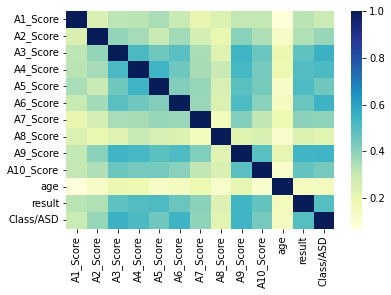

In [4]:
# Feature corr
import matplotlib.pyplot as plt
import seaborn as sns

correlation = data.corr()
sns.heatmap(correlation, cmap="YlGnBu")

## Process features

In [5]:
X_all.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'mode'],
      dtype='object')

In [6]:
# identify categorical and its cardinality for encoding
s = (X.dtypes == 'object')
categorical_cols = list(s[s==True].index)

def encoding(X, categorical_cols):
    # Apply one-hot encoder to each column with categorical data
    from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
    OH_encoder = OrdinalEncoder(handle_unknown='error')
    X_categorical_oh = pd.DataFrame(OH_encoder.fit_transform(X[categorical_cols]))

    # One-hot encoding removed index; put it back
    X_categorical_oh.index = X.index
    return X_categorical_oh
    
def process_features(X, categorical_cols):
    '''
    - no additional processing on numerical features
    - one hot encoding on categorical features
    '''
    X_numerical = X.drop(categorical_cols, axis=1)
    X_categorical_oh = encoding(X, categorical_cols)
    
    # Add one-hot encoded columns to numerical features
    OH_X_train = pd.concat([X_numerical, X_categorical_oh], axis=1)
    return OH_X_train

EX = process_features(X_all, categorical_cols)
print(EX.shape)

(1000, 20)


## Train model

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(EX[EX['mode']==0], y, random_state=11, test_size=0.2)
print(X_train.shape, X_val.shape)

(640, 20) (160, 20)


In [8]:
# Define XGB

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

gbt_model = XGBClassifier(n_estimators=1000, learning_rate=0.04, alpha=1, n_jobs=8)
gbt_model.fit(X_train, y_train, 
             early_stopping_rounds=200, 
             eval_set=[(X_val, y_val)], 
             verbose=False)
pred_val = gbt_model.predict(X_val) # binary prediction
r2_train = gbt_model.score(X_train, y_train)

gbt_acc = accuracy_score(y_val, pred_val)
gbt_roc = roc_auc_score(y_val, pred_val)
print("ROC:{}, Accuracy:{}, r2_train:{}".format(gbt_roc, gbt_acc, r2_train))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


ROC:0.81640625, Accuracy:0.875, r2_train:0.953125


In [9]:
# RidgeClassifier

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

rc_model = RidgeClassifier(alpha=5, fit_intercept=True, random_state=1)
rc_model.fit(X_train, y_train)
pred_val = rc_model.predict(X_val) # binary prediction
r2_train = rc_model.score(X_train, y_train)

rc_acc = accuracy_score(y_val, pred_val)
rc_roc = roc_auc_score(y_val, pred_val)
print("ROC:{}, Accuracy:{}, r2_train:{}".format(rc_roc, rc_acc, r2_train))

ROC:0.8046875, Accuracy:0.85625, r2_train:0.884375


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [10]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import roc_auc_score, accuracy_score

gp_model = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=1)
gp_model.fit(X_train, y_train)
pred_val = gp_model.predict(X_val) # binary prediction
r2_train = gp_model.score(X_train, y_train)

gp_acc = accuracy_score(y_val, pred_val)
gp_roc = roc_auc_score(y_val, pred_val)
print("ROC:{}, Accuracy:{}, r2_train:{}".format(gp_roc, gp_acc, r2_train))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


ROC:0.8203125, Accuracy:0.8625, r2_train:0.8859375


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [11]:
# RidgeClassifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=10, random_state=1)
rf_model.fit(X_train, y_train)
pred_val = rf_model.predict(X_val) # binary prediction
r2_train = rf_model.score(X_train, y_train)

rf_acc = accuracy_score(y_val, pred_val)
rf_roc = roc_auc_score(y_val, pred_val)
print("ROC:{}, Accuracy:{}, r2_train:{}".format(rf_roc, rf_acc, r2_train))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


ROC:0.83203125, Accuracy:0.88125, r2_train:0.9953125


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [12]:
# feature importance
importance = rf_model.feature_importances_
sorted(zip(X_all.columns, importance), key=lambda x:-x[1])

[('gender', 0.13932362564621928),
 ('A3_Score', 0.09795343107115817),
 ('A6_Score', 0.09709911298605406),
 ('A9_Score', 0.09458225292150074),
 ('age', 0.08652434451659925),
 ('A4_Score', 0.08640886803552668),
 ('result', 0.06890459080743741),
 ('austim', 0.06058777304865773),
 ('A5_Score', 0.056210774853208766),
 ('A2_Score', 0.038350971635200806),
 ('A10_Score', 0.033949806958260116),
 ('used_app_before', 0.024406598057377233),
 ('A7_Score', 0.02357193615976277),
 ('contry_of_res', 0.02183161327538825),
 ('mode', 0.01878939962313562),
 ('A1_Score', 0.018451814744218545),
 ('jaundice', 0.01692624760837696),
 ('A8_Score', 0.012284191941053282),
 ('relation', 0.003842646110864376),
 ('ethnicity', 0.0)]

## Submit predictions

In [13]:
# making prediction
test_preds = gp_model.predict(EX[EX['mode']==1])
pd.Series(test_preds).value_counts()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0    162
1     38
dtype: int64

In [14]:
EX[EX['mode']==1].reset_index()

output = pd.DataFrame({'Id': EX[EX['mode']==1].index,
                       label_col: test_preds})
output.to_csv('submission.csv', index=False)